<a href="https://colab.research.google.com/github/gabibu/aiforhealthcare/blob/main/advanced_models_colab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 8.1 MB/s 


In [29]:
from torch.utils.data import Dataset, WeightedRandomSampler
from skimage import io, transform
import os
import pandas as pd
from PIL import Image
import random
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from imageio import imread
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import cm

import pydicom
from abc import ABC, abstractmethod
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from sklearn.model_selection import train_test_split
import cv2

In [3]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


In [4]:
print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_FOLDER ='data'
device

__pyTorch VERSION: 1.11.0+cu113
use_cuda = True


'cuda'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls "/content/drive/My Drive/medical"


aug.weights		simple_preprocessing.weights  weighted_2.weights
dicom-images-train.zip	train-rle.csv		      weighted_sampling.weights


In [8]:
!cp "/content/drive/My Drive/medical/dicom-images-train.zip" "dicom-images-train.zip"


In [9]:
!cp '/content/drive/My Drive/medical/train-rle.csv' "train-rle.csv"


In [10]:
!ls

dicom-images-train.zip	drive  sample_data  train-rle.csv


In [11]:
!unzip  -q dicom-images-train.zip -d data 


In [12]:
SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)
SEED

999

In [ ]:
# df = pd.read_csv('train-rle.csv', header=None, index_col=0)
# train_fns = sorted(glob.glob('data/dicom-images-train/*/*/*.dcm'))
# len(train_fns)
# df_full = pd.read_csv('train-rle.csv', index_col='ImageId')
# df_full.sample(1)

In [14]:
! ls data

dicom-images-train


In [15]:
train_imgs_paths = sorted(glob.glob('data/dicom-images-train/*/*/*.dcm'))
print("Train images size {}".format(len(train_imgs_paths)))

# test_imgs_paths = sorted(glob('../input/siim-acr-pneumothorax-segmentation-data/dicom-images-test/*/*/*.dcm'))
# print("Test images -", len(test_imgs_paths))
# file_paths = train_imgs_paths + test_imgs_paths

Train images size 10712


In [25]:
# data_df = pd.read_csv('train-rle.csv')
# data_df.rename(columns={" EncodedPixels" : "EncodedPixels"}, inplace=True) # a typo in the csv
# data_df.head()
from collections import defaultdict

rles_df = pd.read_csv('train-rle.csv')
rles_df = rles_df.rename(columns={' EncodedPixels':'EncodedPixels'})
rles_df['EncodedPixels'] = rles_df['EncodedPixels'].apply(lambda x: x.strip())

# Create a dictionary for images with masks
rles_df = rles_df[rles_df['EncodedPixels'] !='-1'].groupby('ImageId')['EncodedPixels'].apply(list).reset_index()
print(len(rles_df))

masks = {}
for index, row in rles_df.iterrows():
    masks[row['ImageId']] = row['EncodedPixels']
print(len(masks))

2379
2379


In [44]:
dataset_rows = []
for image_path in train_imgs_paths:
  id = image_path.split('/')[-1][:-4]
  
  mask = masks[id] if id in masks else None
  dataset_rows.append((id, mask, image_path))

dataset_df = pd.DataFrame(dataset_rows, columns = ['image_id', 'rle', 'image_path'])
dataset_df.sample(3)


,image_id,rle,image_path
2576,1.2.276.0.7230010.3.1.4.8323329.12358.15178752...,[611504 6 1 4 1008 23 998 28 994 30 991 32 988...,data/dicom-images-train/1.2.276.0.7230010.3.1....
7016,1.2.276.0.7230010.3.1.4.8323329.31915.15178751...,[313643 2 1021 3 1018 6 1017 7 1015 9 1013 10 ...,data/dicom-images-train/1.2.276.0.7230010.3.1....
3905,1.2.276.0.7230010.3.1.4.8323329.13573.15178752...,None,data/dicom-images-train/1.2.276.0.7230010.3.1....


In [45]:
X_train_df, X_val_df = train_test_split(dataset_df, test_size=0.1, random_state=SEED)
X_train_df.shape, X_val_df.shape

((9640, 3), (1072, 3))

In [92]:
class ImagesDataset(Dataset):
    def __init__(self, df, image_size = 128, preprocesing = None):
        self.df = df
        self.preprocesing = preprocesing
        self.image_size = image_size
        
      
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        row = self.df.iloc[index]

        X = np.zeros((self.image_size, self.image_size))
        y = np.zeros((self.image_size, self.image_size))

        image_path = row['image_path']

        image = pydicom.read_file(image_path).pixel_array
        image_resized = cv2.resize(image, (self.image_size, self.image_size))
        image_resized = np.array(image_resized, dtype=np.float64)


        mask = np.zeros((1024, 1024))

        rle = row['rle']
        if rle is not None:
          for r in rle:
            mask =  mask + rle2mask(r, 1024, 1024).T

        mask_resized = cv2.resize(mask, (self.image_size, self.image_size))

        mask_resized = np.where(mask_resized  > 0, 1, 0)

        #/255
        return image_resized, mask_resized



In [93]:
train_dataset = ImagesDataset(X_train_df)

validation_dataset = ImagesDataset(X_val_df)



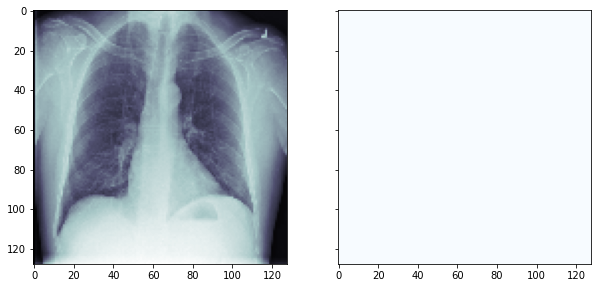

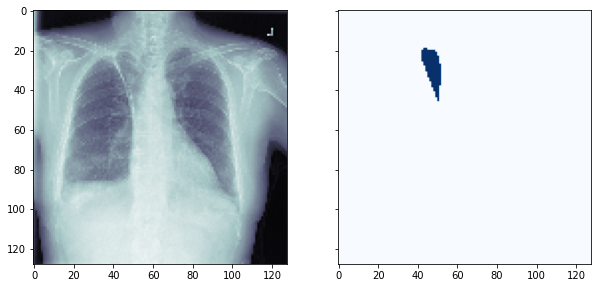

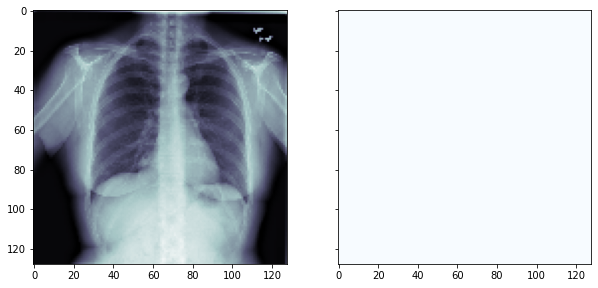

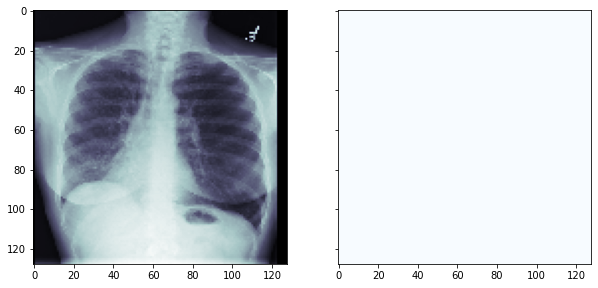

In [94]:
for i in np.random.choice(len(train_dataset), size =4, replace = False):    
    x, y = train_dataset.__getitem__(i)
    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')

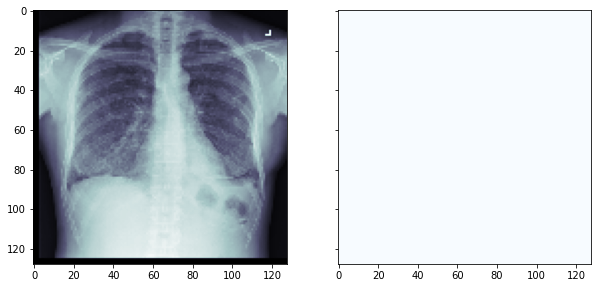

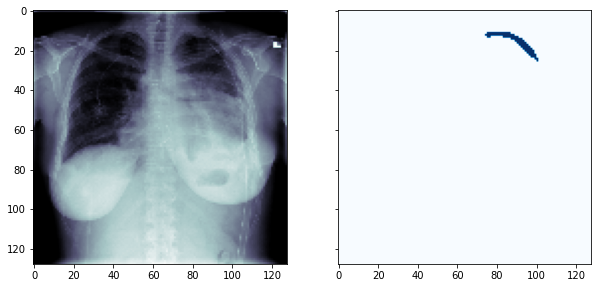

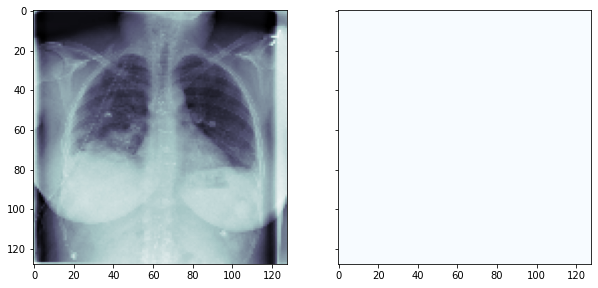

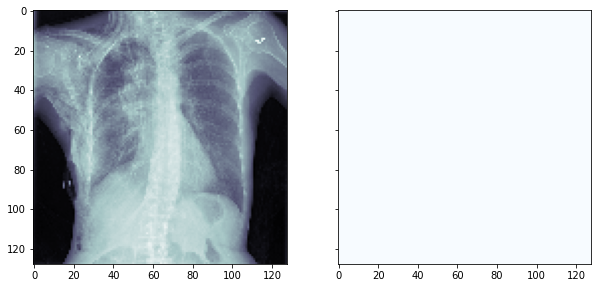

In [109]:

for i in np.random.choice(len(validation_dataset), size =4, replace = False):    
    x, y = validation_dataset.__getitem__(i)
    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')

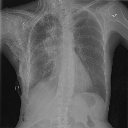

In [118]:
class PreProcessingStep(ABC):
    
    @abstractmethod
    def preprocess(image):
        pass

  
class PreProcessingAugmentations(PreProcessingStep):
    
    def __init__(self, augmentations):
        self.augmentations = augmentations 
    
    def preprocess(self, image):
      
      image =Image.fromarray(image.squeeze(2))

      for aug in self.augmentations:
        image = aug(image)

      return np.expand_dims(np.asarray(image), 2) 


from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ToTensor

torchvision_transform = transforms.Compose([
    RandomHorizontalFlip(0.5),
    RandomVerticalFlip(0.5),
    RandomRotation(0.3)
    #,ToTensor()
])


# myarray = np.random.rand(224, 224)

# from PIL import Image
# from matplotlib import cm
# #im = Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))

im = Image.fromarray(x)

im = im.convert("L")



im2 = torchvision_transform(im)
im
# # im.show()



# mean, std = X_train.mean(), X_train.std()

# preprocessing_normalization = PreProcessingNormalization(mean, std)

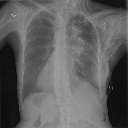

In [119]:
im2